In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize as som
import pickle

from matplotlib import colors as mcolors
from matplotlib import tri
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1 import host_subplot

from cpymad.madx import Madx

%matplotlib inline

import seaborn as sns

sns.set('talk', font_scale=1.2, rc={'figure.figsize':(8.3,5.2), 'lines.linewidth': 3})

sns.set_style('ticks',
               {'grid.linestyle': 'none', 'axes.edgecolor': '0',
                'axes.linewidth': 1.2, 'legend.frameon': True,
                'xtick.direction': 'out', 'ytick.direction': 'out',
                'xtick.top': True, 'ytick.right': True,
               })


In [2]:
# globals 
Qx, Qy = 18.75, 18.95
dk = 5e-3

# pass this from slurm array
global_index = 0

## synchrotron lattice setup

In [3]:
def matching(Qx, Qy):
    match = '''match,sequence=sis100ring;
    VARY,NAME=kqd,STEP=1e-8;
    VARY,NAME=kqf,STEP=1e-8;
    GLOBAL,sequence=sis100ring,Q1={},Q2={};LMDIF,CALLS=2000,TOLERANCE=1.0E-8;
    endmatch;
    twiss; '''.format(Qx, Qy)
    return match


def lattice_setup(Qx, Qy, madx):

    match = matching(Qx, Qy)
    # input for cold lattice
    cold_str = '''CALL, FILE = "Optics-YEH-Jan19-from-Elegant.str";
    CALL, FILE = "sis100cold.seq";

    beam, particle = ion, mass= 221.6955947052, charge=28, sequence=SIS100RING, energy = 269.29559470519996; !beta = 0.5676897813711054;
    use, sequence=SIS100RING;

    kqd : = -2.158585731120552e-01 * LQD;
    kqf : = 2.165932886180960e-01 * LQD;

    K1NL_S00QD1D:=kqd;
    K1NL_S00QD1F:=kqf;
    K1NL_S00QD2F:=kqf;'''
       
    tunes = np.linspace(18.55, Qy, 10)
    twiss_cold_arr = []
    for qy in tunes:
        madx.input(cold_str + matching(Qx, qy))
        twiss = madx.table.twiss.dframe()
        twiss_cold_arr.append(twiss)
    
    return twiss, twiss_cold_arr

## add errors to the lattice

In [4]:
def add_quadrupole_errors(twiss, dk, madx):
    # select quadrupoles
    names = [name.strip()[:-2] for name in twiss[twiss["keyword"].str.contains("quadrupole")]["name"].tolist()]
    
    # generate random errors (python) or take them as an array
    if isinstance(dk, float):
        errors = np.random.normal(0, dk, len(names))
    elif isinstance(arr,np.ndarray):
        errors = dk
    else:
        return False
    # save the object to check error set manually if problems
    pickle.dump(errors, open(f"./results/errors_{global_index}.p", "wb"))
    
    # madx wrap
    add_errors = ""
    for name, error_val in zip(names, errors):
        add_errors += "SELECT, FLAG=error, clear;eoption, add=false;"
        add_errors += f'''SELECT, FLAG=error, PATTERN="{name}*";''' 
        add_errors += '''EFCOMP, ORDER=1, RADIUS=0.01,
        DKNR={0,''' + str(error_val) + "},DKSR={0, 0};\n"
        
    madx.input(add_errors+"twiss;")
    twiss_err = madx.table.twiss.dframe()
    
    return twiss_err

## set correctors

In [5]:
def set_quads(theta, madx):
    add_correctors = '''
    K1NL_S19QS1J:={};
    K1NL_S1DQS1J:={};
    K1NL_S29QS1J:={};
    K1NL_S2DQS1J:={};
    K1NL_S39QS1J:={};
    K1NL_S3DQS1J:={};
    K1NL_S49QS1J:={};
    K1NL_S4DQS1J:={};
    K1NL_S59QS1J:={};
    K1NL_S5DQS1J:={};
    K1NL_S69QS1J:={};
    K1NL_S6DQS1J:={};
    
    K1NL_S14KM1Q:={};
    K1NL_S1EKM1Q:={};
    K1NL_S24KM1Q:={};
    K1NL_S2EKM1Q:={};
    K1NL_S34KM1Q:={};
    K1NL_S3EKM1Q:={};
    K1NL_S44KM1Q:={};
    K1NL_S4EKM1Q:={};
    K1NL_S54KM1Q:={};
    K1NL_S5EKM1Q:={};
    K1NL_S64KM1Q:={};
    K1NL_S6EKM1Q:={};
    '''.format(*theta)
    madx.input(add_correctors + "twiss;")
    
    return madx.table.summ.q1[0], madx.table.summ.q2[0]


## observables

In [6]:
def find_betabeat(twiss_ref, twiss_curr):
    
    beat_x = np.std(twiss_curr["betx"] / twiss_ref["betx"] - 1.)
    beat_y = np.std(twiss_curr["bety"] / twiss_ref["bety"] - 1.)
    
    return np.sqrt(beat_x**2 + beat_y**2)

def find_stopband(theta, twiss_ref_arr, madx):
    out = []
    tunes = np.linspace(18.55, 18.95, 10)
    for idx, Qy in enumerate(tunes):
        set_quads(theta, madx)
        madx.input(matching(Qx, Qy)) # twiss after matching already there
        twiss_curr = madx.table.twiss.dframe()
        tmp = find_betabeat(twiss_ref_arr[idx], twiss_curr)
        out.append(tmp)
    return np.array(out)

def objective(theta, twiss_ref_arr, stopband_initial, madx):
    out = find_stopband(theta, twiss_ref_arr, madx) / stopband_initial
    #print(out)
    # large values lay at resonances, drop them
    return np.mean(sorted(out)[:-2])

## correction

In [7]:
def correct_lattice(stopband0, twiss_cold_arr, madx):
    # try to replace with optuna (optionally)
    method = 'COBYLA'
    epsilon, maxiter = 1e-3, 10000

    theta = np.zeros(24) # initial guess

    optionsDict = {'rhobeg':epsilon, 'maxiter':maxiter ,'disp': True}

    arg = (twiss_cold_arr, stopband0, madx)

    vec = som(objective, theta, method=method, options=optionsDict, args=arg)
    
    return vec

## prepare output

In [8]:

def prepare_output(vec, stopband0, stopband_fin, twiss):
    
    df = pd.DataFrame()

    # it would be better to use here the width!!
    df['stopband_initial'] = [np.mean(stopband0)] 
    df['stopband_final'] = [np.mean(stopband_fin)] 

    df["success"] = [vec.success]

    corr_variables = ['K1NL_S19QS1J','K1NL_S1DQS1J','K1NL_S29QS1J','K1NL_S2DQS1J','K1NL_S39QS1J','K1NL_S3DQS1J',
                      'K1NL_S49QS1J','K1NL_S4DQS1J','K1NL_S59QS1J','K1NL_S5DQS1J','K1NL_S69QS1J','K1NL_S6DQS1J',
                      'K1NL_S14KM1Q','K1NL_S1EKM1Q','K1NL_S24KM1Q','K1NL_S2EKM1Q','K1NL_S34KM1Q','K1NL_S3EKM1Q',
                      'K1NL_S44KM1Q','K1NL_S4EKM1Q','K1NL_S54KM1Q','K1NL_S5EKM1Q','K1NL_S64KM1Q','K1NL_S6EKM1Q'
    ]

    for i, name in enumerate(corr_variables):
        # times 1000 to keep precision
        df[name] = [1e3*vec.x[i]]
    
    bpmx = twiss[twiss["keyword"].str.contains("hmonitor")][["name", "betx"]]
    bpmy = twiss[twiss["keyword"].str.contains("vmonitor")][["name", "bety"]]

    for name, beta in zip(bpmx["name"], bpmx["betx"]):
        df[name[:-2]] = [beta]

    for name, beta in zip(bpmy["name"], bpmy["bety"]):
        df[name[:-2]] = [beta]
        
    return df

## run all

In [9]:
madx = Madx(stdout=False)
twiss, twiss_cold_arr = lattice_setup(Qx,Qy, madx)
twiss_err = add_quadrupole_errors(twiss, dk, madx)
theta = np.zeros(24)
stopband0 = find_stopband(theta, twiss_cold_arr, madx)
vec = correct_lattice(stopband0, twiss_cold_arr, madx)

In [10]:
stopband_fin = find_stopband(vec.x, twiss_cold_arr, madx)

In [11]:
df = prepare_output(vec, stopband0, stopband_fin, twiss_err)

In [12]:
df.to_csv(f"./results/output_{global_index}.csv", index=False)

In [13]:
Qx, Qy = 18.75, 18.75

In [14]:
theta = np.zeros(24)
madx.input(matching(Qx, Qy))
qx,qy = set_quads(theta, madx)
print(f"current tunes are:\nQx={Qx}\nQy={Qy}")
twiss_err = madx.table.twiss.dframe()

current tunes are:
Qx=18.75
Qy=18.75


In [15]:
theta = vec.x
madx.input(matching(Qx, Qy))
qx,qy = set_quads(theta, madx)
print(f"current tunes are:\nQx={Qx}\nQy={Qy}")
twiss_curr = madx.table.twiss.dframe()

current tunes are:
Qx=18.75
Qy=18.75


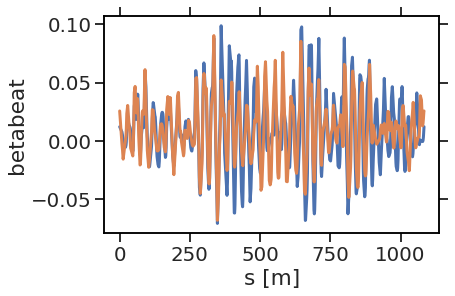

In [16]:
plt.plot(twiss_err['s'], twiss_err['bety'] / twiss['bety'] - 1)
plt.plot(twiss_curr['s'], twiss_curr['bety'] / twiss['bety'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();

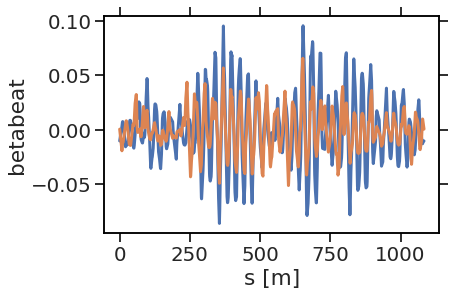

In [17]:
plt.plot(twiss_err['s'], twiss_err['betx'] / twiss['betx'] - 1)
plt.plot(twiss_curr['s'], twiss_curr['betx'] / twiss['betx'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();